In [1]:
# test.py

import os
import sys

PROJECT_ROOT = "/Users/lohitakshbadarala/Desktop/AIM-VEE"
sys.path.append(PROJECT_ROOT)

import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib  # to load saved scaler / PCA

from src.aimvee.models.VEE_predictor import vee_predictor as Model
from src.aimvee.vee_predictor_utils.load_dataset import Dataset
from src.aimvee.vee_predictor_utils.train_utils import eval_epoch



DATA_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/data/vee_predictor/Data"
MODEL_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/models/predictor"
MODEL_PATH = os.path.join(MODEL_DIR, "best_cm_model.pt")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_X.pkl")
PCA_PATH    = os.path.join(MODEL_DIR, "pca_X.pkl")

CM_TO_EV = 1.239841984e-4  # convert cm^-1 -> eV

In [2]:
DATA_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/data/vee_predictor/Data"
MODEL_DIR = "/Users/lohitakshbadarala/Desktop/AIM-VEE/models/predictor"
MODEL_PATH = os.path.join(MODEL_DIR, "best_cm_model.pt")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler_X.pkl")
PCA_PATH    = os.path.join(MODEL_DIR, "pca_X.pkl")

CM_TO_EV = 1.239841984e-4  # convert cm^-1 -> eV


In [4]:
X_test = np.load(os.path.join(DATA_DIR, "CM_test.npy"))
y_test = np.load(os.path.join(DATA_DIR, "EV_test.npy"))

print("Test shapes:", X_test.shape, y_test.shape)

# 2) Drop invalid targets (y < 0), same as train/val
mask_test = y_test >= 0
print(f"Dropping {np.sum(~mask_test)} invalid test rows (y < 0)")

X_test = X_test[mask_test]
y_test = y_test[mask_test]

    # 3) Separate representation (CM) from indices (fid, state)
d_rep = X_test.shape[1] - 2
X_test_rep = X_test[:, :d_rep]   # CM rep
X_test_idx = X_test[:, d_rep:]   # (fid, state)

    # 4) Load scaler + PCA fitted on training data
    #    (Make sure your training script saved these!)
scaler_X: StandardScaler = joblib.load(SCALER_PATH)
pca: PCA = joblib.load(PCA_PATH)

    # 5) Apply scaling + PCA to test representation
X_test_rep = scaler_X.transform(X_test_rep)
X_test_rep = pca.transform(X_test_rep)

new_d_rep = X_test_rep.shape[1]
print("Test representation dim after PCA:", new_d_rep)

    # 6) Rejoin PCA rep with fid/state
X_test = np.concatenate([X_test_rep, X_test_idx], axis=1)

    # 7) Build Dataset + DataLoader
test_ds = Dataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

d_rep    = test_ds.d_rep
n_fids   = test_ds.n_fids
n_states = test_ds.n_states

print(f"[TEST] d_rep={d_rep}, n_fids={n_fids}, n_states={n_states}")

    # 8) Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

    # 9) Rebuild model with same hyperparameters as training
model = Model(
    d_rep=d_rep,
    n_fids=n_fids,
    n_states=n_states,
    hidden_dim=512,
     emb_dim=32,
    dropout=0.2,
).to(device)

    # 10) Load best saved weights
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Could not find model checkpoint at {MODEL_PATH}")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
print(f"Loaded model weights from: {MODEL_PATH}")

    # 11) Evaluate on test set
test_mae_cm = eval_epoch(model, test_loader, device=device)
test_mae_ev = test_mae_cm * CM_TO_EV

print(
    f"\n=== FINAL TEST RESULTS ===\n"
    f"Test MAE: {test_mae_cm:.2f} cm^-1 ({test_mae_ev:.6f} eV)\n"
)

Test shapes: (130000, 255) (130000,)
Dropping 0 invalid test rows (y < 0)
Test representation dim after PCA: 100
[TEST] d_rep=100, n_fids=5, n_states=10
Using Apple MPS GPU
Loaded model weights from: /Users/lohitakshbadarala/Desktop/AIM-VEE/models/predictor/best_cm_model.pt


/opt/anaconda3/envs/aim_vee/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/aim_vee/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/aim_vee/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/aim_vee/lib/python3.10/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/opt/anaconda3/envs/aim_vee/lib/python3.10/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/opt/anaconda3/e


=== FINAL TEST RESULTS ===
Test MAE: 624.46 cm^-1 (0.077424 eV)



In [5]:
def collect_predictions(model, loader, device):
    model.eval()
    ys, preds, fids, states = [], [], [], []

    with torch.no_grad():
        for batch in loader:
            feats  = batch["feats"].to(device).float()
            fid_id = batch["fid_id"].to(device).long()
            state  = batch["state_id"].to(device).long()
            y      = batch["target"].to(device).float()

            y_hat = model(feats, fid_id, state)

            ys.append(y.cpu().numpy())
            preds.append(y_hat.cpu().numpy())
            fids.append(fid_id.cpu().numpy())
            states.append(state.cpu().numpy())

    return (
        np.concatenate(ys),
        np.concatenate(preds),
        np.concatenate(fids),
        np.concatenate(states),
    )

y_true_cm, y_pred_cm, fid_ids, state_ids = collect_predictions(model, test_loader, device)

y_true_ev = y_true_cm * CM_TO_EV
y_pred_ev = y_pred_cm * CM_TO_EV
errors_ev = np.abs(y_pred_ev - y_true_ev)

print("Collected predictions successfully.")


Collected predictions successfully.


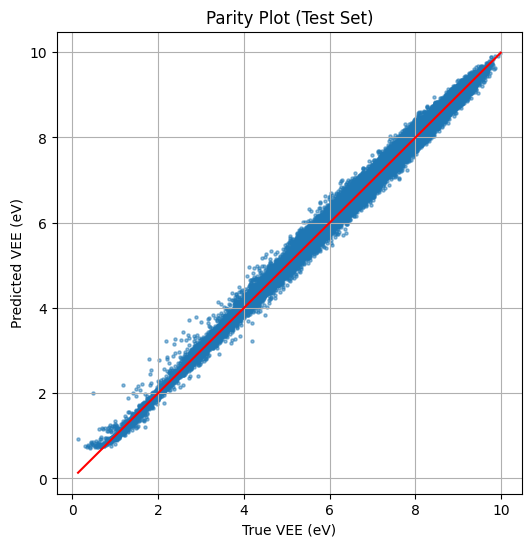

In [6]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(6,6))
plt.scatter(y_true_ev, y_pred_ev, s=5, alpha=0.5)

min_val = min(y_true_ev.min(), y_pred_ev.min())
max_val = max(y_true_ev.max(), y_pred_ev.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red")

plt.xlabel("True VEE (eV)")
plt.ylabel("Predicted VEE (eV)")
plt.title("Parity Plot (Test Set)")
plt.grid(True)
plt.show()


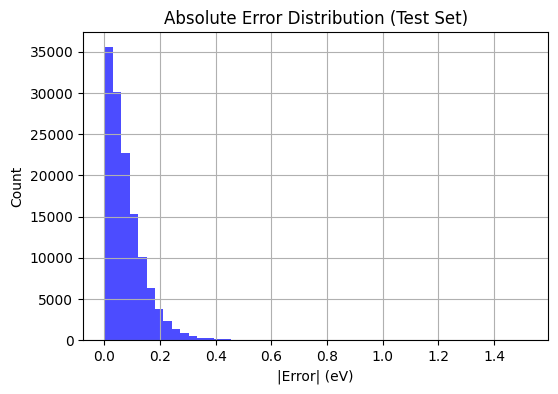

In [7]:
plt.figure(figsize=(6,4))
plt.hist(errors_ev, bins=50, color="blue", alpha=0.7)
plt.xlabel("|Error| (eV)")
plt.ylabel("Count")
plt.title("Absolute Error Distribution (Test Set)")
plt.grid(True)
plt.show()


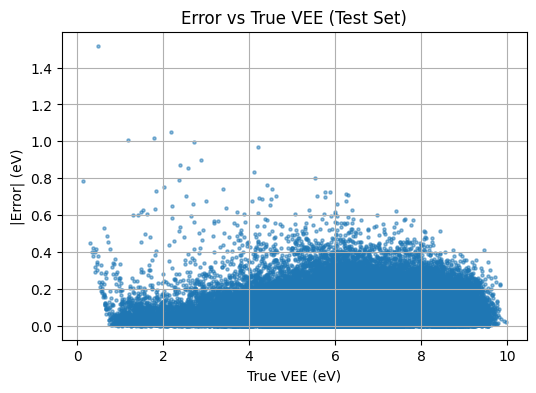

In [8]:
plt.figure(figsize=(6,4))
plt.scatter(y_true_ev, errors_ev, s=5, alpha=0.5)
plt.xlabel("True VEE (eV)")
plt.ylabel("|Error| (eV)")
plt.title("Error vs True VEE (Test Set)")
plt.grid(True)
plt.show()


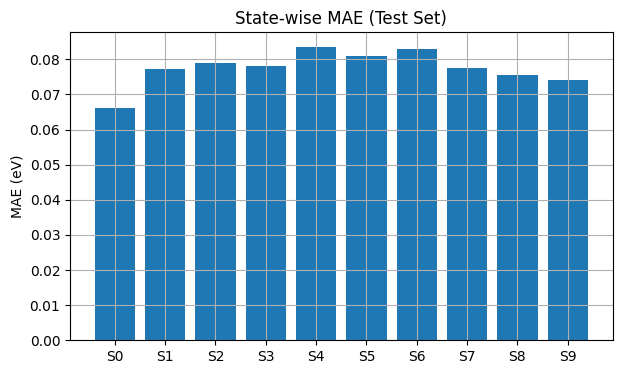

In [9]:
unique_states = np.unique(state_ids)
mae_by_state = []

for s in unique_states:
    mask = (state_ids == s)
    mae_s = np.mean(np.abs(y_pred_ev[mask] - y_true_ev[mask]))
    mae_by_state.append(mae_s)

plt.figure(figsize=(7,4))
plt.bar([f"S{s}" for s in unique_states], mae_by_state)
plt.ylabel("MAE (eV)")
plt.title("State-wise MAE (Test Set)")
plt.grid(True)
plt.show()


In [10]:
print(X_test.shape)
print(y_test.shape)


(130000, 102)
(130000,)
